In [1]:
import tifffile as tf
from scipy import ndimage
import numpy as np

import os
import glob
from importlib import reload

import warnings
warnings.filterwarnings( "ignore")
from matplotlib import pyplot as plt
%matplotlib inline

import walnut_utils as wnut

In [2]:
fs = 15
resol = 0.0759

src = '../hpcc/clean/'
dst = '../hpcc/watershed/'

struc1 = ndimage.generate_binary_structure(3, 1)
struc2 = ndimage.generate_binary_structure(3, 2)
struc3 = ndimage.generate_binary_structure(3, 3)

ssrange = [100,150,200,250,300]

Sx = [ np.s_[k,:,:] for k in ssrange ]
Sy = [ np.s_[:,k,:] for k in ssrange ]
Sz = [ np.s_[:,:,k] for k in ssrange ]

fs = 15

In [3]:
idname = '2014SBa'

rownum = 5
treenum = 49
nutnum = 1

bname = idname + '_R{}_T{}'.format(rownum, treenum)
print(bname)

wdst = dst + bname + '/'
if not os.path.isdir(wdst):
    os.makedirs(wdst)
wdstd = wdst + 'diagnostic/'
if not os.path.isdir(wdstd):
    os.makedirs(wdstd)
wdsts = wdst + 'snaps/'
if not os.path.isdir(wdsts):
    os.makedirs(wdsts)
print(wdsts)

2014SBa_R5_T49
../hpcc/watershed/2014SBa_R5_T49/snaps/


In [4]:
fname = bname + '_{:03d}'.format(nutnum)
print(fname)

img = tf.imread(src + bname + '/' + fname + '.tif')
mxval = 2**(8*img.itemsize)-1

2014SBa_R5_T49_001


# Meat

In [5]:
mimg = img.copy()

eimg = ndimage.binary_erosion(mimg, struc2, 15, border_value=1)
mimg = eimg*mimg
mimg = ndimage.uniform_filter(mimg)

mimg[mimg < 120] = 0

In [6]:
minim = ndimage.minimum_filter(mimg, size=5)

minimv = minim.flatten()
minimv = minimv[minimv > 0]

meanv = np.mean(minimv)
sdv = np.std(minimv)

print('Minimum ', meanv, sdv, meanv-2.25*sdv, sep='\t')

tminim = minim.copy()
tminim[tminim < meanv-2.25*sdv] = 0
tminim[tminim > 230] = 0

Minimum 	158.1277299866242	10.623627050821877	134.22456912227497


In [7]:
#eimg = ndimage.binary_erosion(tminim, struc1, 1, border_value=1)

#eimg = ndimage.binary_dilation(tminim, struc1, 1, border_value=0)
eimg = wnut.get_largest_element(tminim, 0.1)

207 components	 1 preserved
[14998386    19750    13477    11546     8086     3838     2190     2003
      968      843      614      550      329      320      265      241
      200      151      145       80]


In [8]:
dimg = ndimage.binary_dilation(eimg, struc1, 10, border_value=0)

if False:
    dimg = ndimage.binary_dilation(dimg, struc1, 4, border_value=0)
    dimg = ndimage.binary_erosion(dimg, struc1, 6, border_value=1)
    dimg = ndimage.binary_dilation(dimg, struc1, 2, border_value=0)

In [9]:
meat = (dimg*img).copy()
meat[meat < 120] = 0

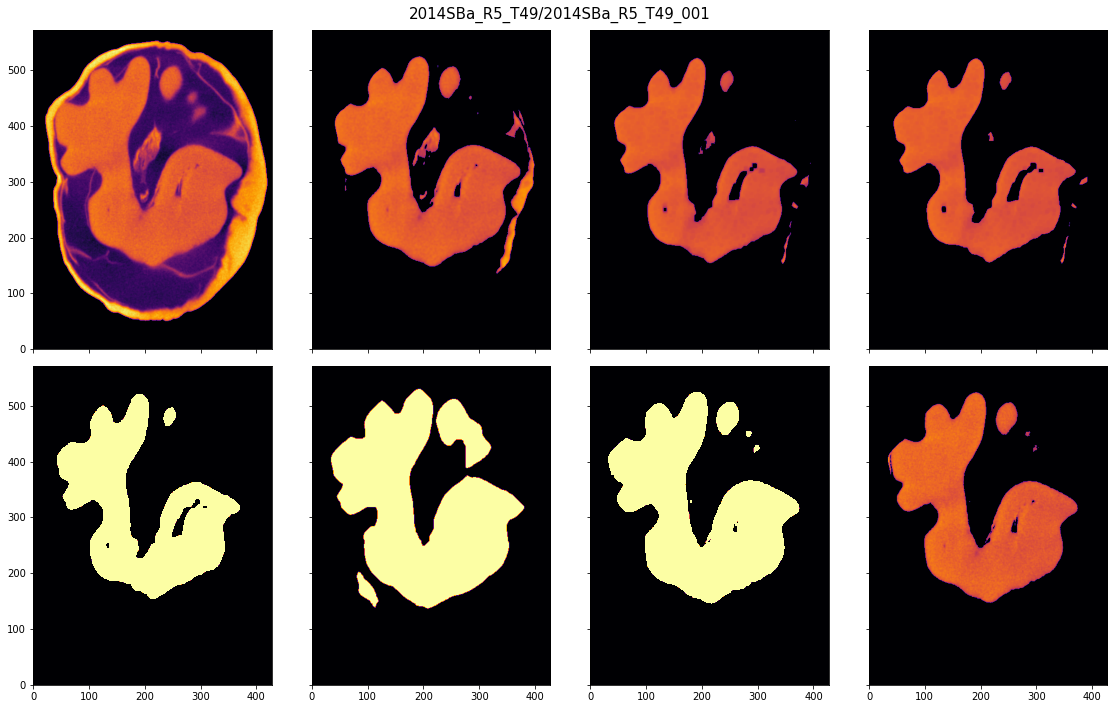

In [10]:
k = 205
ss = np.s_[150:400,k,250:]
ss = np.s_[:,k,:]

fig, ax = plt.subplots(2,4,figsize=(16,10), sharex=True, sharey=True)
ax = np.atleast_1d(ax).flatten()

i = 0
ax[i].imshow(img[ss], cmap='inferno', origin='lower', vmax=255, vmin=0)
i = 1
ax[i].imshow(mimg[ss], cmap='inferno', origin='lower', vmax=255, vmin=0)
i = 2
ax[i].imshow(minim[ss], cmap='inferno', origin='lower', vmax=255, vmin=0)
i = 3
ax[i].imshow(tminim[ss], cmap='inferno', origin='lower', vmax=255, vmin=0)
i = 4
ax[i].imshow(eimg[ss], cmap='inferno', origin='lower', vmax=1, vmin=0)
i = 5
ax[i].imshow(dimg[ss], cmap='inferno', origin='lower', vmax=1, vmin=0)
i = 6
ax[i].imshow(meat[ss], cmap='inferno', origin='lower', vmax=1, vmin=0)
i = 7
ax[i].imshow(meat[ss], cmap='inferno', origin='lower', vmax=255, vmin=0)

fig.suptitle(bname + '/' + fname, fontsize=fs)

fig.tight_layout()

# Shell

In [11]:
dist = ndimage.distance_transform_cdt(img, 'taxicab')

In [12]:
bshell = (img > 160) & (dist < 7)

In [13]:
timg = img.copy()
timg[timg == 0] = mxval
timg[meat > 0] = 0

timg = ndimage.binary_erosion(timg, struc2, 7, border_value=1)

timg[img < 150] = 0

In [14]:
eimg = ndimage.binary_erosion(timg, struc2, 3, border_value=1)
eimg = wnut.get_largest_element(timg)
#eimg = ndimage.binary_dilation(eimg, struc2, 1, border_value=0)

1326 components	 1 preserved
[7574865   60987   26339    3466    1555    1119     860     479     407
     387     378     362     351     275     246     164     141     141
     130     114]


In [15]:
cshell = img*eimg
cshell[cshell < 180] = 0
cshell = wnut.get_largest_element(cshell)
cshell[cshell > 0] = 1

284 components	 1 preserved
[6085563     385     238     232     194     114     114      91      65
      63      43      30      30      24      24      23      21      19
      19      19]


In [16]:
dshell = ndimage.binary_dilation(cshell, struc1, 5, border_value=0)
dshell = ndimage.binary_erosion(dshell, struc1, 2, border_value=1)

In [17]:
mshell = dshell | bshell
shell = (img*mshell).copy()
shell[shell < 160] = 0

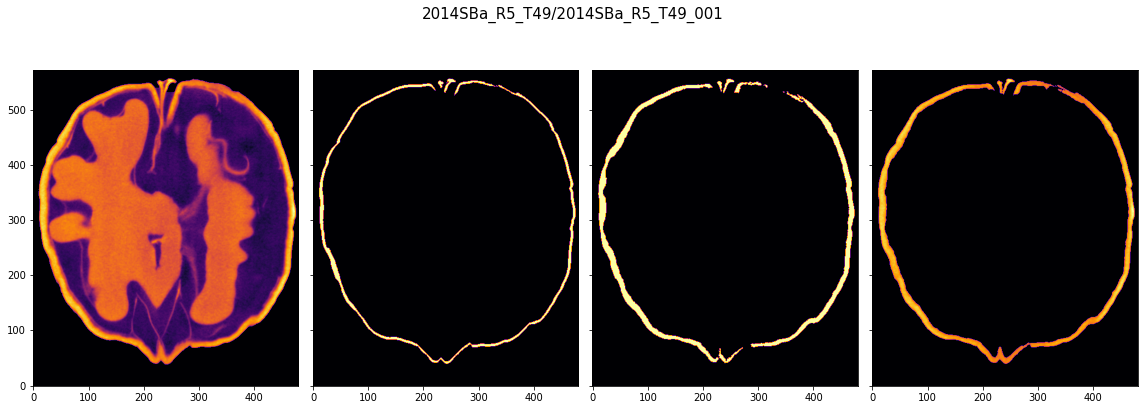

In [18]:
k = 250
ss = np.s_[150:400,k,250:]
ss = np.s_[:,:,k]

fig, ax = plt.subplots(1,4,figsize=(16,6), sharex=True, sharey=True)
ax = np.atleast_1d(ax).flatten()

i = 0
ax[i].imshow(img[ss], cmap='inferno', origin='lower', vmax=255, vmin=0)
i = 1
ax[i].imshow(bshell[ss], cmap='inferno', origin='lower', vmax=1, vmin=0)
i = 2
ax[i].imshow(cshell[ss], cmap='inferno', origin='lower', vmax=1, vmin=0)
i = 3
ax[i].imshow(shell[ss], cmap='inferno', origin='lower', vmax=255, vmin=0)

fig.suptitle(bname + '/' + fname, fontsize=fs)
fig.tight_layout()

# Veins

In [19]:
vimg = img.copy()
vimg[meat > 0] = 0
#vimg = ndimage.binary_erosion(vimg, struc1, 1, border_value=1)

vimg[shell > 0] = 0
vimg = ndimage.binary_erosion(vimg, struc1, 2, border_value=1)

In [20]:
vein = img*vimg
vein[vein < 75] = 0
vein[vein > 190] = 0

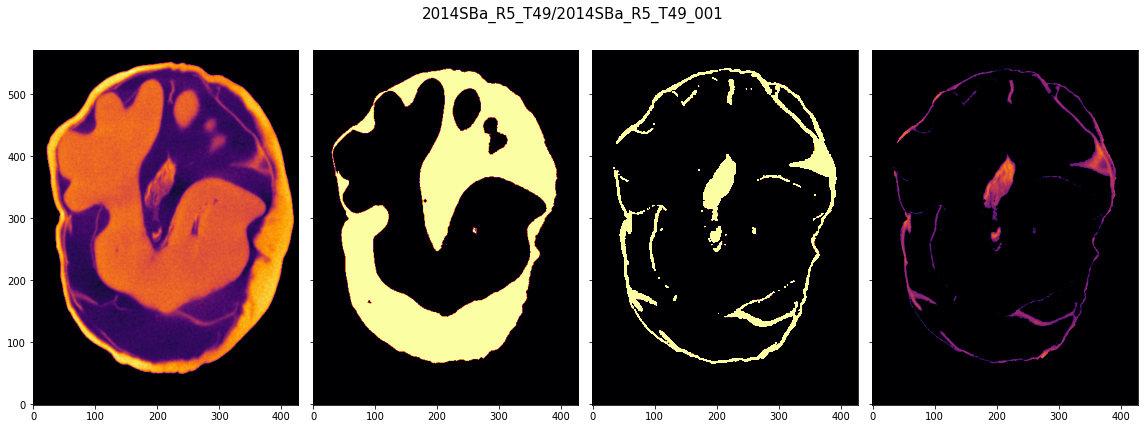

In [21]:
k = 205
ss = np.s_[:,k,:]

fig, ax = plt.subplots(1,4,figsize=(16,6), sharex=True, sharey=True)
ax = np.atleast_1d(ax).flatten()

i = 0
ax[i].imshow(img[ss], cmap='inferno', origin='lower', vmax=255, vmin=0)
i = 1
ax[i].imshow(vimg[ss], cmap='inferno', origin='lower', vmax=1, vmin=0)
i = 2
ax[i].imshow(vein[ss], cmap='inferno', origin='lower', vmax=1, vmin=0)
i = 3
ax[i].imshow(vein[ss], cmap='inferno', origin='lower', vmax=255, vmin=0)

fig.suptitle(bname + '/' + fname, fontsize=fs)
fig.tight_layout()

# Air

In [22]:
aimg = img.copy()

aimg[img > 65] = 0
aimg[meat > 0] = 0
aimg[shell > 0] = 0
aimg[vein > 0] = 0
aimg[aimg > 0] = 1

#aimg = ndimage.binary_erosion(aimg, struc2, 2, border_value=1)
#aimg = wnut.get_largest_element(aimg)

In [23]:
air = img*aimg

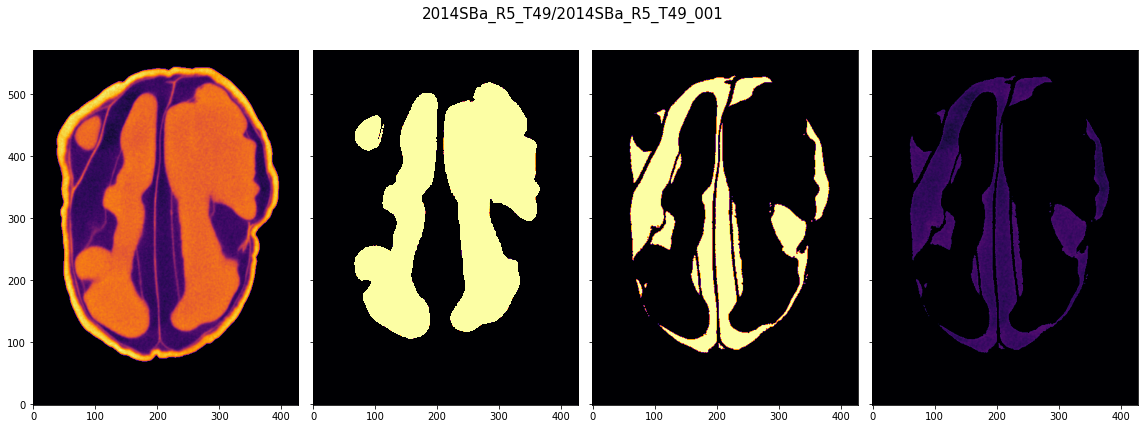

In [24]:
k = 155
ss = np.s_[150:400,k,250:]
ss = np.s_[:,k,:]

fig, ax = plt.subplots(1,4,figsize=(16,6), sharex=True, sharey=True)
ax = np.atleast_1d(ax).flatten()

i = 0
ax[i].imshow(img[ss], cmap='inferno', origin='lower', vmax=255, vmin=0)
i = 1
ax[i].imshow(meat[ss], cmap='inferno', origin='lower', vmax=1, vmin=0)
i = 2
ax[i].imshow(aimg[ss], cmap='inferno', origin='lower', vmax=1, vmin=0)
i = 3
ax[i].imshow(air[ss], cmap='inferno', origin='lower', vmax=255, vmin=0)

fig.suptitle(bname + '/' + fname, fontsize=fs)
fig.tight_layout()

# Watershed

In [25]:
markers = np.copy(img).astype(int)
markers[markers == 0] = -1
markers[markers > 0] = 0

for i,tissue in enumerate([meat,shell,vein,air]):
    markers[tissue > 0] = i+1
    
ift = ndimage.watershed_ift(img, markers)

In [26]:
tissues = [None for x in range(4)]
for i in range(len(tissues)):
    mask = ift == i+1
    box = img.copy()
    box[~mask] = 0
    
    tissues[i] = box

# Save and plot

In [27]:
tissue = ['meat','shell','vein','air']

for i in range(len(tissue)):
    filename = wdst + fname + '_' + tissue[i] + '.tif'
    tf.imwrite(filename, tissues[i], photometric='minisblack', compress=3)
    #print(filename)

In [28]:
for i in range(len(tissue)):
    snaps = wnut.collapse_dimensions(tissues[i])
    wnut.plot_collapse_dimensions(snaps, fname, tissue[i], dst=wdsts, writefig=True, display=False)

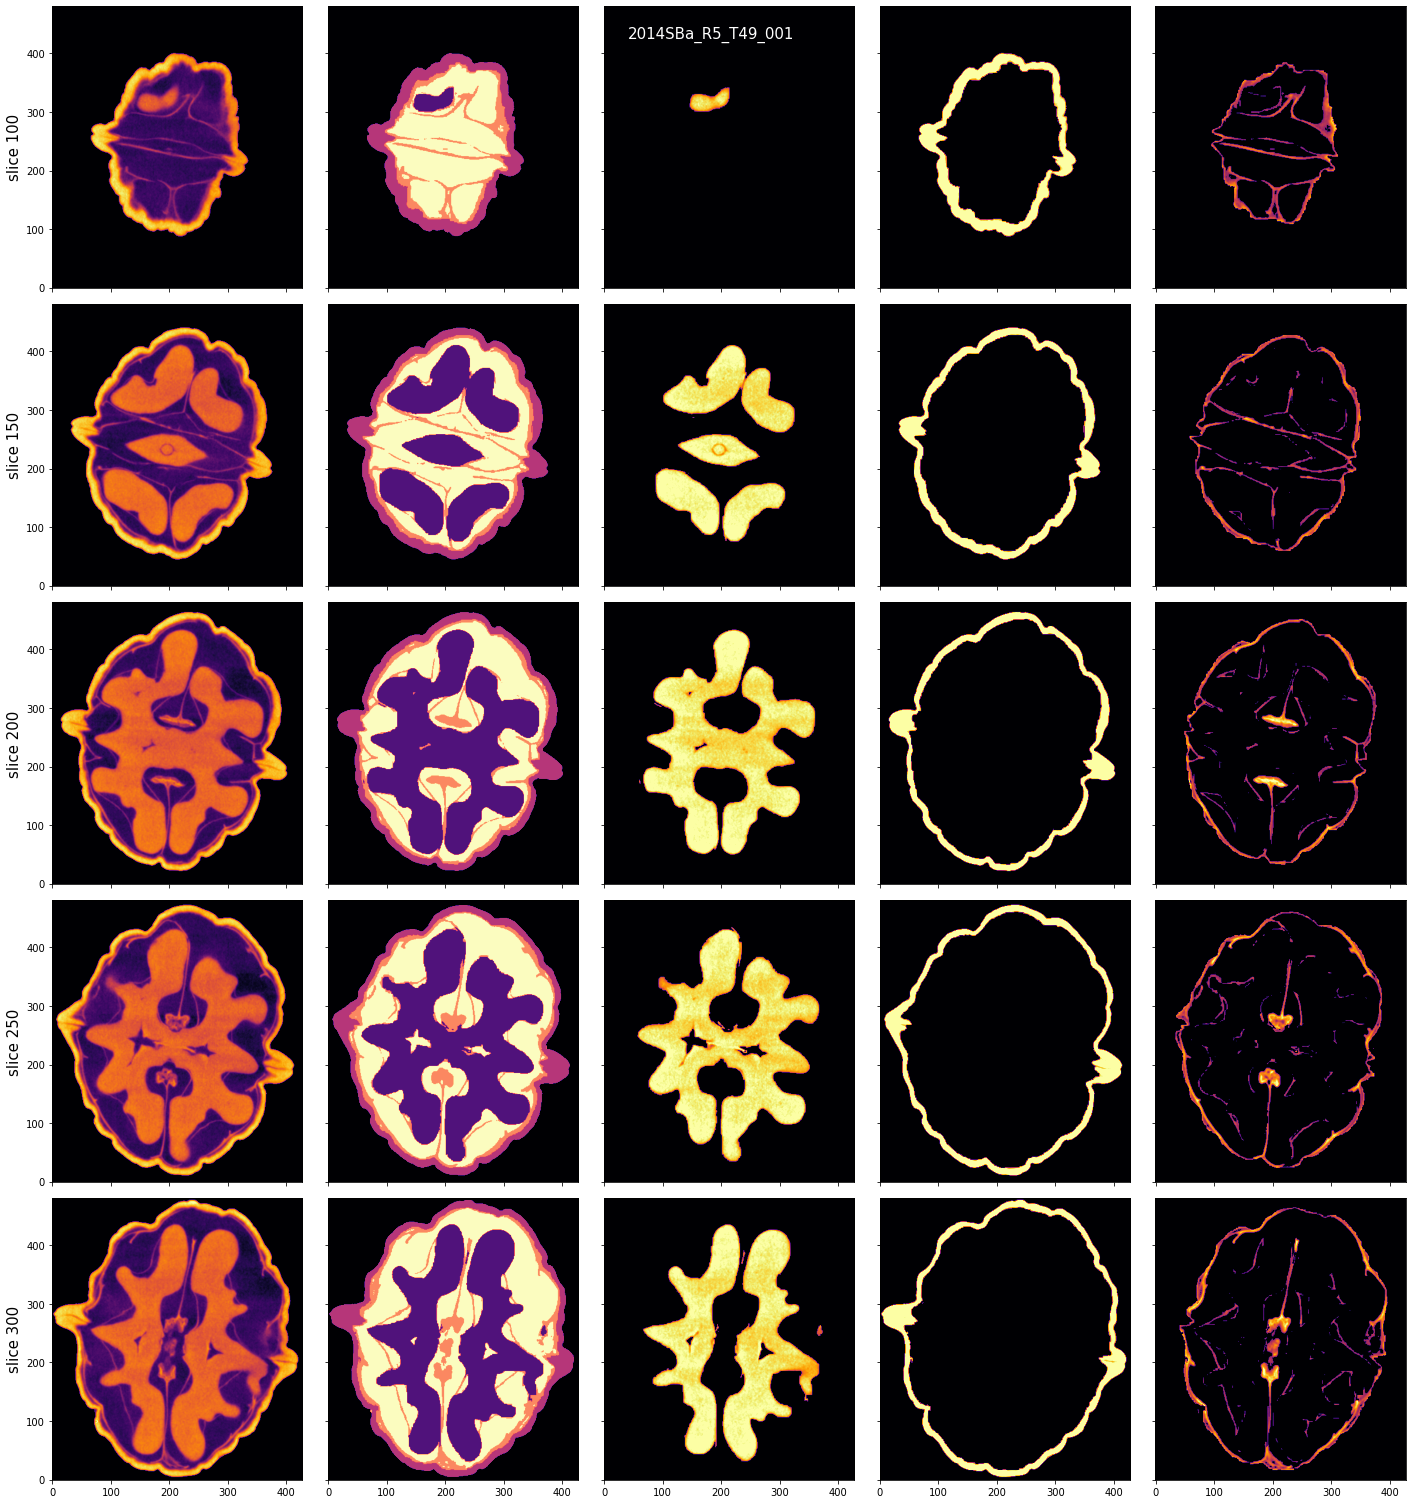

In [29]:
k = 200

ss = np.s_[150:400,k,250:]
ss = np.s_[:,k,:]

j = 0
ss = Sx[j]
    
fig, ax = plt.subplots(5,5,figsize=(20,21), sharex=True, sharey=True)
#ax = np.atleast_1d(ax).flatten()
for j in range(5):
    ss = Sx[j]
    i = 0
    ax[j,i].imshow(img[ss], cmap='inferno', origin='lower', vmax=255, vmin=0)
    ax[j,i].set_ylabel('slice {}'.format(ssrange[j]), fontsize=fs)
    i = 1
    ax[j,i].imshow(ift[ss], cmap='magma', origin='lower', vmin=0)
    for i in range(2,5):
        ax[j,i].imshow(tissues[i-2][ss], cmap='inferno', origin='lower', vmax=175, vmin=0)
fig.tight_layout()
fig.suptitle(fname, fontsize=fs, color='white');

filename = wdstd + fname + '_x.jpg'
plt.savefig(filename, dpi=96, format='jpg', bbox_inches = 'tight', pil_kwargs={'optimize':True})
#plt.close()

In [30]:
fig, ax = plt.subplots(5,5,figsize=(20,21), sharex=True, sharey=True)
for j in range(5):
    ss = Sy[j]
    i = 0
    ax[j,i].imshow(img[ss], cmap='inferno', origin='lower', vmax=255, vmin=0)
    ax[j,i].set_ylabel('slice {}'.format(ssrange[j]), fontsize=fs)
    i = 1
    ax[j,i].imshow(ift[ss], cmap='magma', origin='lower', vmin=0)
    for i in range(2,5):
        ax[j,i].imshow(tissues[i-2][ss], cmap='inferno', origin='lower', vmax=175, vmin=0)
fig.tight_layout()
fig.suptitle(fname, fontsize=fs, color='white');

filename = wdstd + fname + '_y.jpg'
plt.savefig(filename, dpi=96, format='jpg', bbox_inches = 'tight', pil_kwargs={'optimize':True})
plt.close()

In [31]:
fig, ax = plt.subplots(5,5,figsize=(20,21), sharex=True, sharey=True)
for j in range(5):
    ss = Sz[j]
    i = 0
    ax[j,i].imshow(img[ss], cmap='inferno', origin='lower', vmax=255, vmin=0)
    ax[j,i].set_ylabel('slice {}'.format(ssrange[j]), fontsize=fs)
    i = 1
    ax[j,i].imshow(ift[ss], cmap='magma', origin='lower', vmin=0)
    for i in range(2,5):
        ax[j,i].imshow(tissues[i-2][ss], cmap='inferno', origin='lower', vmax=175, vmin=0)
fig.tight_layout()
fig.suptitle(fname, fontsize=fs, color='white');

filename = wdstd + fname + '_z.jpg'
plt.savefig(filename, dpi=96, format='jpg', bbox_inches = 'tight', pil_kwargs={'optimize':True})
plt.close()

# Get the interior shell

In [413]:
PAD = 34

interior = img.copy()
interior[shell > 0] = 0
interior[vein  > 0] = 0
interior = np.pad(interior, PAD)


dint = ndimage.binary_dilation(interior, struc1, PAD-3, border_value=0)
#eint = ndimage.binary_erosion(dint, struc1, 3, border_value=0)
cint = ndimage.binary_erosion(dint, struc1, PAD-3, border_value=1)

In [414]:
print(img.shape, cint.shape)
eint = ndimage.binary_erosion(cint, struc1, 20, border_value=1)
eint = eint[PAD:-PAD, PAD:-PAD, PAD:-PAD]
print(eint.shape)

(502, 377, 385) (570, 445, 453)
(502, 377, 385)


In [415]:
intshell = shell*eint

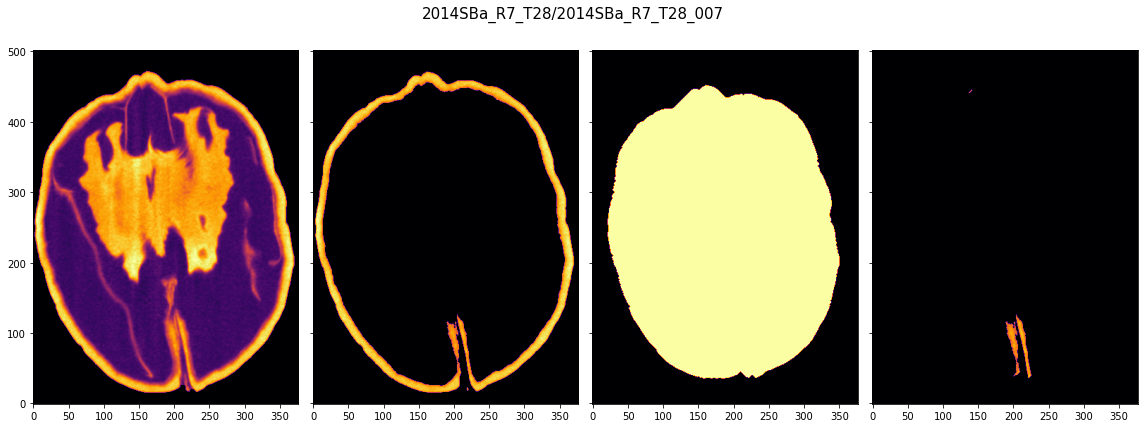

In [416]:
k = 215
ss = np.s_[:,:,k]

fig, ax = plt.subplots(1,4,figsize=(16,6), sharex=True, sharey=True)
ax = np.atleast_1d(ax).flatten()

i = 0
ax[i].imshow(img[ss], cmap='inferno', origin='lower', vmax=255, vmin=0)
i = 1
ax[i].imshow(shell[ss], cmap='inferno', origin='lower', vmax=255, vmin=0)
i = 2
ax[i].imshow(eint[ss], cmap='inferno', origin='lower', vmax=1, vmin=0)
i = 3
#ax[i].imshow(eint[ss], cmap='inferno', origin='lower', vmax=1, vmin=0)
ax[i].imshow(intshell[ss], cmap='inferno', origin='lower', vmax=255, vmin=0)

fig.suptitle(bname + '/' + fname, fontsize=fs)
fig.tight_layout()

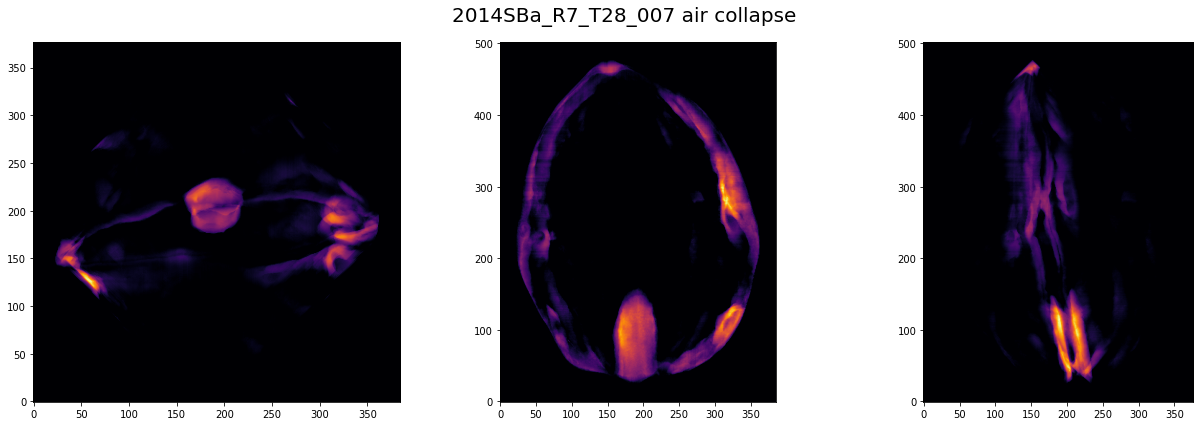

In [417]:
snaps = wnut.collapse_dimensions(intshell)
wnut.plot_collapse_dimensions(snaps, fname, tissue[i], dst=wdsts, writefig=False, display=True)